### Exercise 3
---
Use the code below to simulate new data.
Generate data and then decode the stimulus identity, see how the decoding performance change when you change the following:

- The amplitude of the noise in the firing rate

Plot and comment.

In [17]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pickle
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import warnings
warnings.filterwarnings('ignore')

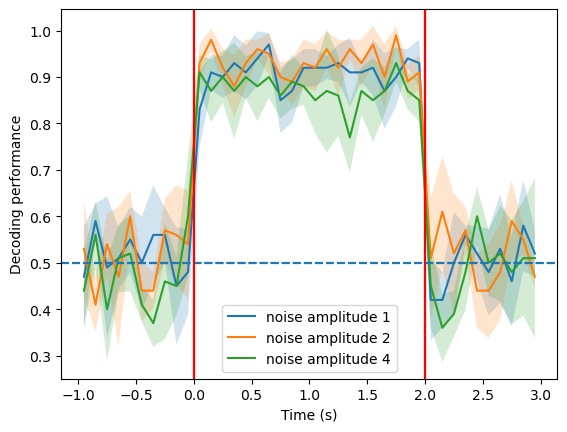

In [26]:
noise_amplitude_array = [1,2,4]
for i in range(len(noise_amplitude_array)):
    
    n_cells = 20; # number of cells to simulate
    n_stim_type = 2; # number of different stimuli
    sigma_stim = 0.5 # amplitude of stimulus related modulation
    average_firing_rate = 5; # average firing rate across the population

    # generate baseline rates from exponential distirbution
    cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)

    # create stimulus average responses, perturbing the population firng rate profile
    # we use a multiplicative modulation in opposite directions for the two stimuli
    modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
    cell_rate_stim = {1: cell_rate_baseline * (1+modulation),2:cell_rate_baseline * (1-modulation)}
    # sets negative firng rate to 0
    cell_rate_stim[1][cell_rate_stim[1]<0]=0
    cell_rate_stim[2][cell_rate_stim[2]<0]=0
    
    # simulate spiking activity
    s_rate = 10000 # the sampling rate of our emulated recording system
    noise_rate = noise_amplitude_array[i] # we are going to add some spike noise non related to the task
    n_stim = 100 # number of stimuli

    stim_dur = 2 #stimulus duration (in seconds)
    is_interval = 3 # interval between stimuli  (in seconds)

    stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
    stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
    np.random.shuffle(stim_type)

    time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.

    spike_times = []
    for cell in range(n_cells):
        spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
        for i,stimulus in enumerate(stim_type):
            stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
            spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)

        spike_times.append(time[spikes>0])

    # save ouput
    out_dict = {'spike_times':spike_times,
                'stim_onsets':stim_onsets,
                'stim_type':stim_type,
                'stim_duration':stim_dur
                }
    
    with open('data/simulated_data1.pickle', 'wb') as handle:
        pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    onset = -1 # in seconds before stimulus onset
    offset = 1 # in second after stimulus offset

    binwidth = 0.1 # in seconds (100 ms)
    bins = np.arange(onset,stim_dur+offset+binwidth,binwidth)
    
    onset = 1 # in seconds before stimulus onset
    offset = 1 # in second after stimulus offset

    binwidth = 0.1 # in seconds (100 ms)
    bins = np.arange(-onset,stim_dur+offset+binwidth,binwidth)

    n_cells = len(spike_times)
    n_trials= len(stim_type)

    X = np.zeros((n_cells,n_trials,len(bins)-1));
    for cell in range(n_cells):    
        for trial in range(n_trials):

            # selects spikes that are in trial
            sp_idx = np.logical_and(spike_times[cell]>stim_onsets[trial]-onset,
                     spike_times[cell]<stim_onsets[trial]+stim_dur+offset)

            # centers spike times around stimulus onset
            sp_cntr = spike_times[cell][sp_idx]-stim_onsets[trial]
            #bins spikes
            spike_count,_ = np.histogram(sp_cntr,bins)
            #spike_count = zscore(spike_count)
            X[cell,trial,:] = spike_count

    from sklearn.model_selection import StratifiedKFold
    from sklearn import svm
    from sklearn.preprocessing import StandardScaler

    n_splits = 5

    avg_performance = []
    std_performance = []

    for time_bin in range(X.shape[-1]):
            # setting 2-fold cross validation
            kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
            fold_performance = []

            for train_index, test_index in kf.split(X[:,:,time_bin].T,stim_type):


                    X_train, X_test = X[:,train_index,time_bin].T, X[:,test_index,time_bin].T
                    y_train, y_test = stim_type[train_index], stim_type[test_index]

                    clf = svm.LinearSVC(max_iter=1000)
                    clf.fit(X_train, y_train)
                    fold_performance.append(clf.score(X_test,y_test))

            avg_performance.append(np.mean(fold_performance))
            std_performance.append(np.std(fold_performance))

    avg_performance = np.asarray(avg_performance)
    std_performance = np.asarray(std_performance)

    bin_centers = [(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
    plt.plot(bin_centers,avg_performance,label=f'noise amplitude {noise_rate}')
    plt.fill_between(bin_centers,avg_performance-std_performance,
                     avg_performance+std_performance,alpha=0.2)

    plt.axhline(y=0.5,linestyle='--')
    plt.axvline(x=0,c='r')
    plt.axvline(x=2,c='r')

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Decoding performance')




There is no real difference between in performances between the different noise amplitudes.

- The amplitude of the stimulus modulation of the firing rate

Plot and comment.

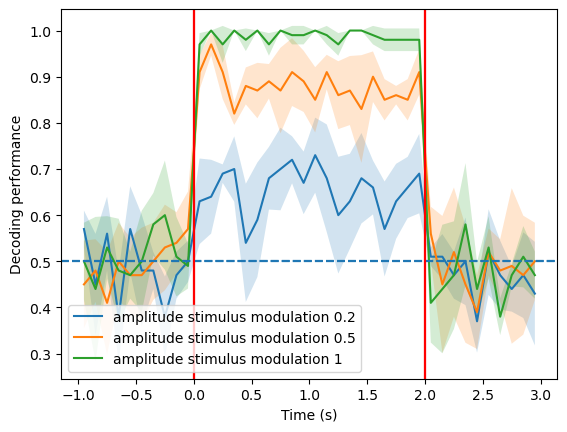

In [23]:
sigma_stim_array = [0.2,0.5,1]
for i in range(len(sigma_stim_array)):
    
    n_cells = 20; # number of cells to simulate
    n_stim_type = 2; # number of different stimuli
    sigma_stim = sigma_stim_array[i] # amplitude of stimulus related modulation
    average_firing_rate = 5; # average firing rate across the population

    # generate baseline rates from exponential distirbution
    cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)

    # create stimulus average responses, perturbing the population firng rate profile
    # we use a multiplicative modulation in opposite directions for the two stimuli
    modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
    cell_rate_stim = {1: cell_rate_baseline * (1+modulation),2:cell_rate_baseline * (1-modulation)}
    # sets negative firng rate to 0
    cell_rate_stim[1][cell_rate_stim[1]<0]=0
    cell_rate_stim[2][cell_rate_stim[2]<0]=0
    
    # simulate spiking activity
    s_rate = 10000 # the sampling rate of our emulated recording system
    noise_rate = 1 # we are going to add some spike noise non related to the task
    n_stim = 100 # number of stimuli

    stim_dur = 2 #stimulus duration (in seconds)
    is_interval = 3 # interval between stimuli  (in seconds)

    stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
    stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
    np.random.shuffle(stim_type)

    time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.

    spike_times = []
    for cell in range(n_cells):
        spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
        for i,stimulus in enumerate(stim_type):
            stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
            spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)

        spike_times.append(time[spikes>0])

    # save ouput
    out_dict = {'spike_times':spike_times,
                'stim_onsets':stim_onsets,
                'stim_type':stim_type,
                'stim_duration':stim_dur
                }
    
    with open('data/simulated_data1.pickle', 'wb') as handle:
        pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    onset = -1 # in seconds before stimulus onset
    offset = 1 # in second after stimulus offset

    binwidth = 0.1 # in seconds (100 ms)
    bins = np.arange(onset,stim_dur+offset+binwidth,binwidth)
    
    onset = 1 # in seconds before stimulus onset
    offset = 1 # in second after stimulus offset

    binwidth = 0.1 # in seconds (100 ms)
    bins = np.arange(-onset,stim_dur+offset+binwidth,binwidth)

    n_cells = len(spike_times)
    n_trials= len(stim_type)

    X = np.zeros((n_cells,n_trials,len(bins)-1));
    for cell in range(n_cells):    
        for trial in range(n_trials):

            # selects spikes that are in trial
            sp_idx = np.logical_and(spike_times[cell]>stim_onsets[trial]-onset,
                     spike_times[cell]<stim_onsets[trial]+stim_dur+offset)

            # centers spike times around stimulus onset
            sp_cntr = spike_times[cell][sp_idx]-stim_onsets[trial]
            #bins spikes
            spike_count,_ = np.histogram(sp_cntr,bins)
            #spike_count = zscore(spike_count)
            X[cell,trial,:] = spike_count

    from sklearn.model_selection import StratifiedKFold
    from sklearn import svm
    from sklearn.preprocessing import StandardScaler

    n_splits = 5

    avg_performance = []
    std_performance = []

    for time_bin in range(X.shape[-1]):
            # setting 2-fold cross validation
            kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
            fold_performance = []

            for train_index, test_index in kf.split(X[:,:,time_bin].T,stim_type):


                    X_train, X_test = X[:,train_index,time_bin].T, X[:,test_index,time_bin].T
                    y_train, y_test = stim_type[train_index], stim_type[test_index]

                    clf = svm.LinearSVC(max_iter=1000)
                    clf.fit(X_train, y_train)
                    fold_performance.append(clf.score(X_test,y_test))

            avg_performance.append(np.mean(fold_performance))
            std_performance.append(np.std(fold_performance))

    avg_performance = np.asarray(avg_performance)
    std_performance = np.asarray(std_performance)

    bin_centers = [(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
    plt.plot(bin_centers,avg_performance,label=f'amplitude stimulus modulation {sigma_stim}')
    plt.fill_between(bin_centers,avg_performance-std_performance,
                     avg_performance+std_performance,alpha=0.2)

    plt.axhline(y=0.5,linestyle='--')
    plt.axvline(x=0,c='r')
    plt.axvline(x=2,c='r')

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Decoding performance')




The higher the amplitude of the simulus modulation of the firing rate, the higher the decoding performance. 

- The number of neurons

Plot and comment.

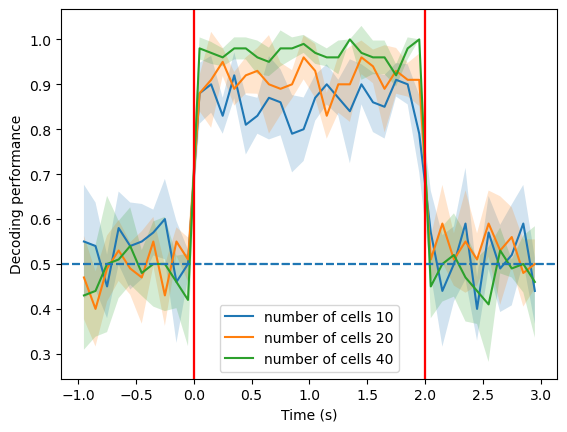

In [24]:
n_cells_array = [10,20,40]
for i in range(len(n_cells_array)):
    
    n_cells = n_cells_array[i]; # number of cells to simulate
    n_stim_type = 2; # number of different stimuli
    sigma_stim = 0.5 # amplitude of stimulus related modulation
    average_firing_rate = 5; # average firing rate across the population

    # generate baseline rates from exponential distirbution
    cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)

    # create stimulus average responses, perturbing the population firng rate profile
    # we use a multiplicative modulation in opposite directions for the two stimuli
    modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
    cell_rate_stim = {1: cell_rate_baseline * (1+modulation),2:cell_rate_baseline * (1-modulation)}
    # sets negative firng rate to 0
    cell_rate_stim[1][cell_rate_stim[1]<0]=0
    cell_rate_stim[2][cell_rate_stim[2]<0]=0
    
    # simulate spiking activity
    s_rate = 10000 # the sampling rate of our emulated recording system
    noise_rate = 1 # we are going to add some spike noise non related to the task
    n_stim = 100 # number of stimuli

    stim_dur = 2 #stimulus duration (in seconds)
    is_interval = 3 # interval between stimuli  (in seconds)

    stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
    stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
    np.random.shuffle(stim_type)

    time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.

    spike_times = []
    for cell in range(n_cells):
        spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
        for i,stimulus in enumerate(stim_type):
            stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
            spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)

        spike_times.append(time[spikes>0])

    # save ouput
    out_dict = {'spike_times':spike_times,
                'stim_onsets':stim_onsets,
                'stim_type':stim_type,
                'stim_duration':stim_dur
                }
    
    with open('data/simulated_data1.pickle', 'wb') as handle:
        pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    onset = -1 # in seconds before stimulus onset
    offset = 1 # in second after stimulus offset

    binwidth = 0.1 # in seconds (100 ms)
    bins = np.arange(onset,stim_dur+offset+binwidth,binwidth)
    
    onset = 1 # in seconds before stimulus onset
    offset = 1 # in second after stimulus offset

    binwidth = 0.1 # in seconds (100 ms)
    bins = np.arange(-onset,stim_dur+offset+binwidth,binwidth)

    n_cells = len(spike_times)
    n_trials= len(stim_type)

    X = np.zeros((n_cells,n_trials,len(bins)-1));
    for cell in range(n_cells):    
        for trial in range(n_trials):

            # selects spikes that are in trial
            sp_idx = np.logical_and(spike_times[cell]>stim_onsets[trial]-onset,
                     spike_times[cell]<stim_onsets[trial]+stim_dur+offset)

            # centers spike times around stimulus onset
            sp_cntr = spike_times[cell][sp_idx]-stim_onsets[trial]
            #bins spikes
            spike_count,_ = np.histogram(sp_cntr,bins)
            #spike_count = zscore(spike_count)
            X[cell,trial,:] = spike_count

    from sklearn.model_selection import StratifiedKFold
    from sklearn import svm
    from sklearn.preprocessing import StandardScaler

    n_splits = 5

    avg_performance = []
    std_performance = []

    for time_bin in range(X.shape[-1]):
            # setting 2-fold cross validation
            kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
            fold_performance = []

            for train_index, test_index in kf.split(X[:,:,time_bin].T,stim_type):


                    X_train, X_test = X[:,train_index,time_bin].T, X[:,test_index,time_bin].T
                    y_train, y_test = stim_type[train_index], stim_type[test_index]

                    clf = svm.LinearSVC(max_iter=1000)
                    clf.fit(X_train, y_train)
                    fold_performance.append(clf.score(X_test,y_test))

            avg_performance.append(np.mean(fold_performance))
            std_performance.append(np.std(fold_performance))

    avg_performance = np.asarray(avg_performance)
    std_performance = np.asarray(std_performance)

    bin_centers = [(bins[i+1]+bins[i])/2 for i in range(len(bins)-1)]
    plt.plot(bin_centers,avg_performance,label=f'number of cells {n_cells}')
    plt.fill_between(bin_centers,avg_performance-std_performance,
                     avg_performance+std_performance,alpha=0.2)

    plt.axhline(y=0.5,linestyle='--')
    plt.axvline(x=0,c='r')
    plt.axvline(x=2,c='r')

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Decoding performance')




comment

More neurons also results in a slightly higher performance.